In [1]:
# Librerías generales
import numpy as np
from collections import defaultdict
from functools import reduce
from itertools import product
import random
import scipy
import matplotlib.pyplot as plt

# Librerías Qibo
import qibo
from qibo import models, gates, hamiltonians
from qibo import matrices as m

# Librerías Qiskit
import qiskit
from qiskit import IBMQ, QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.algorithms.optimizers import COBYLA, SPSA, POWELL
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import X, Z, I, Y
from qiskit.circuit.library import TwoLocal
from qiskit.tools.parallel import parallel_map

random.seed()

qibo.set_backend("numpy")

%matplotlib inline

/tmp/ipykernel_18913/2196755265.py:19: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, SPSA, POWELL
[Qibo 0.1.12.dev0|INFO|2024-05-22 13:14:32]: Using numpy backend on /CPU:0


In [2]:
op = np.array([[2.5,-1,-0.5,0],[-1,2.5,0,0.5],[-0.5,0,2.5,1],[0,0.5,1,2.5]], dtype=complex)

eigvals, eigvecs = scipy.linalg.eig(op)

print("Autovalores:", np.sort(np.real(eigvals)))
print("Autovalor mínimo:", np.real(np.round(min(eigvals))))

Autovalores: [1. 2. 3. 4.]
Autovalor mínimo: 1.0


In [3]:
PAULIS = {
    "I": np.eye(2, dtype=complex),
    "X": np.array([[0,1],[1,0]], dtype=complex),
    "Y": np.array([[0,-1j],[1j,0]], dtype=complex),
    "Z": np.array([[1,0],[0,-1]], dtype=complex)
}

In [4]:
def pauli_decomposition(H):

    n = int(np.log2(len(H)))
    dims = 2**n
    
    if H.shape != (dims,dims):
        raise ValueError("La matriz debe tener dimensiones 2^n x 2^n")
        
    basis_key = ["".join(k) for k in product(PAULIS.keys(), repeat = n)]
    components = defaultdict(int)
    
    for i, val in enumerate(product(PAULIS.values(), repeat=n)):
        basis_mat = reduce(np.kron, val)
        coeff = H.reshape(-1).dot(basis_mat.reshape(-1)) / dims
        coeff = np.real_if_close(coeff).item()
        
        if not np.allclose(coeff,0):
            components[basis_key[i]] = coeff
            
    return components

In [5]:
components = pauli_decomposition(op)
components

defaultdict(int, {'II': 2.5, 'XZ': -0.5, 'ZX': -1.0})

In [6]:
restr = components['II']*np.kron(PAULIS["I"],PAULIS["I"]) + components['XZ']*np.kron(PAULIS["X"],PAULIS["Z"]) + components['ZX']*np.kron(PAULIS["Z"],PAULIS["X"])

print(restr)

if restr.all() == op.all(): print("\n Las dos matrices son iguales.")

[[ 2.5+0.j -1. +0.j -0.5+0.j  0. +0.j]
 [-1. +0.j  2.5+0.j  0. +0.j  0.5+0.j]
 [-0.5+0.j  0. +0.j  2.5+0.j  1. +0.j]
 [ 0. +0.j  0.5+0.j  1. +0.j  2.5+0.j]]

 Las dos matrices son iguales.


In [7]:
'''Qibo_code_cell'''

def ansatz(circuit, nqubits, thetas, rounds=3):

    for r in range(rounds):
        for i in range(nqubits):
            offset = r*nqubits*2 + i*2
                        
            circuit.add(gates.RY(i, thetas[offset]))
            circuit.add(gates.RZ(i, thetas[offset+1]))
            
            if i > 0 and r < rounds - 1:
                circuit.add(gates.CNOT(i-1, i))
                
    return circuit

In [8]:
'''Qibo_code_cell'''

nqubits = 3
nrounds = 4

qc = models.circuit.Circuit(nqubits)
angles = np.random.rand(2*nqubits*nrounds)

qc = ansatz(qc, nqubits=nqubits, thetas=angles, rounds=nrounds)

print(qc.draw())

q0: ─RY─RZ─o─────────RY─RZ─o─────────RY─RZ─o─────────RY─RZ─
q1: ─RY─RZ─X───────o─RY─RZ─X───────o─RY─RZ─X───────o─RY─RZ─
q2: ─────────RY─RZ─X─────────RY─RZ─X─────────RY─RZ─X─RY─RZ─


In [9]:
'''Qibo_code_cell'''

def matrix_decomposition_circuits(H, add_ansatz):

    from qibo import models, gates

    # Definimos variables y comprobamos las dimensiones del Hamiltoniano
    n = int(np.log2(len(H)))
    dims = 2**n
    
    if H.shape != (dims,dims):
        raise ValueError("La matriz debe tener dimensiones 2^n x 2^n")
        
    # Descomponemos el Hamiltoniano en cadenas de Pauli
    components = pauli_decomposition(H)
    
    circuits = {}
    for (paulistring, weight) in components.items():
        paulis = list(enumerate(reversed(paulistring)))
        qc = models.Circuit(n)
        
        # No hacemos nada si todas las Pauli son I, utilizamos este circuito vacío que medirá el estado "0" (autovalor 1) en todos los caso
        if all(x[1] == "I" for x in paulis):
            qc.add(gates.M(qc.nqubits-1))
            circuits[paulistring] = (qc, weight)
            continue

        # Al resto de posibles circuitos sí les añadimos el ansatz
        add_ansatz(qc,n)
            
        # Hacemos las transformaciones sobre un solo qubit
        for idx, letter in paulis:
            if letter == "X":
                qc.add(gates.H(idx))
            elif letter == "Y":
                qc.add(gates.H(idx))
                qc.add(gates.S(idx).dagger())
                
        # Añadimos las puertas multiqubit
        for idx, (first, second) in enumerate(zip(paulis, paulis[1:])):
            if second[1] == "I":
                qc.add(gates.SWAP(first[0], second[0]))
            elif first[1] != "I":
                paulis[idx+1] = (paulis[idx+1][0], paulis[idx][1])
                qc.add(gates.CNOT(first[0],second[0]))
                
        # Medimos sobre el último qubit
        qc.add(gates.M(qc.nqubits-1))
        circuits[paulistring] = (qc, weight)
        
        
    return circuits

In [10]:
'''Qibo_code_cell'''

def run_circuit(circuit, shots=10000):
    result = circuit.execute(nshots=shots)
    counts = result.frequencies(binary=True)
    return ((counts["0"] if "0" in counts.keys() else 0) - (counts["1"] if "1" in counts.keys() else 0))/shots

In [11]:
'''Qibo_code_cell'''

def expectation(H, rounds, thetas):
    circuits = matrix_decomposition_circuits(H, lambda qc,n: ansatz(qc, n, thetas, rounds))
    
    return sum(map(lambda key: run_circuit(circuits[key][0])*circuits[key][1], circuits.keys()))

In [12]:
class SPSA:
    
    def __init__(self, a, c, A, alpha, gamma, H, loss_function):
        # Inicializamos parámetros de ganancia y factores de decaímiento
        self.a = a
        self.c = c
        self.A = A
        self.alpha = alpha
        self.gamma = gamma
        self.loss_function = loss_function
        
        # Contador
        self.t = 0
        
    def step(self, current_estimate):
        # Obtenemos los valores actuales para las secuencias de ganancia
        a_t = self.a / (self.t + 1 + self.A)**self.alpha
        c_t = self.c / (self.t + 1)**self.gamma
        
        # Vector de perturbaciones aleatorias de la distribución de Bernoulli
        delta = np.random.randint(0, 2, np.array(current_estimate).shape) * 2 - 1
        
        # Medimos la función de pérdida en las perturbaciones
        loss_plus = self.loss_function(current_estimate + delta * c_t)
        loss_minus = self.loss_function(current_estimate - delta * c_t)
        
        # Estimación del gradiente
        g_t = (loss_plus - loss_minus) / (2.0 * delta * c_t)
        
        # Actualizamos la estimación del parámetro
        current_estimate = current_estimate - a_t * g_t
        
        # Incrementamos el contador
        self.t +=1
        
        return current_estimate

In [13]:
def vqe(H, rounds, max_iter, thetas=None, save_steps = None):
   
    cnt_qubits = int(np.log2(len(H)))
    if thetas is None:
        thetas = list(map(lambda x: random.random(), [0] * ((1+rounds)*cnt_qubits*2)))
        
    # Creamos la clase del optimizador
    optimizer = SPSA(a = 0.9, c = 1.0, A = max_iter/10, alpha = 0.602, gamma = 0.101, H = H, loss_function = lambda t_thetas: expectation(H, rounds, t_thetas))
    
    # Loop principal
    for i in range(max_iter):
        thetas = optimizer.step(thetas)
        
        if save_steps is not None and i % save_steps == 0:
            yield (i, thetas, expectation(H, rounds, thetas))
            
    return (thetas, expectation(H, rounds, thetas))

In [14]:
H = op

result = None
step_size = 3

result_energy = []

for step in vqe(H, rounds=3, max_iter=1002, save_steps = step_size):
    result_energy.append(step[2])
    print('Paso {step}. Valor actual de la función de coste: {ev: .3f}'.format(step=step[0], ev = step[2]))
    result = step
    
print('Los parámetros óptimos para este circuito son: [\n'
     + "".join(["\t"+str(round(t,3))
     +",\n" if i%3 == 2 else "\t"+str(round(t,3))
     +",\t" for i, t in enumerate(result[1])])+"]")
print('El valor del autovalor mínimo es: {ev: .3f}'.format(ev=result[2]))

Paso 0. Valor actual de la función de coste:  3.385
Paso 3. Valor actual de la función de coste:  3.382
Paso 6. Valor actual de la función de coste:  3.348
Paso 9. Valor actual de la función de coste:  3.327
Paso 12. Valor actual de la función de coste:  3.304
Paso 15. Valor actual de la función de coste:  3.248
Paso 18. Valor actual de la función de coste:  3.266
Paso 21. Valor actual de la función de coste:  3.275
Paso 24. Valor actual de la función de coste:  3.199
Paso 27. Valor actual de la función de coste:  3.155
Paso 30. Valor actual de la función de coste:  3.183
Paso 33. Valor actual de la función de coste:  3.171


Paso 36. Valor actual de la función de coste:  3.085


Paso 39. Valor actual de la función de coste:  3.062
Paso 42. Valor actual de la función de coste:  3.056
Paso 45. Valor actual de la función de coste:  3.040


Paso 48. Valor actual de la función de coste:  2.983
Paso 51. Valor actual de la función de coste:  2.867
Paso 54. Valor actual de la función de coste:  2.776
Paso 57. Valor actual de la función de coste:  2.735
Paso 60. Valor actual de la función de coste:  2.614
Paso 63. Valor actual de la función de coste:  2.547
Paso 66. Valor actual de la función de coste:  2.508
Paso 69. Valor actual de la función de coste:  2.436
Paso 72. Valor actual de la función de coste:  2.437
Paso 75. Valor actual de la función de coste:  2.403
Paso 78. Valor actual de la función de coste:  2.369
Paso 81. Valor actual de la función de coste:  2.357
Paso 84. Valor actual de la función de coste:  2.319


Paso 87. Valor actual de la función de coste:  2.267


Paso 90. Valor actual de la función de coste:  2.230
Paso 93. Valor actual de la función de coste:  2.159
Paso 96. Valor actual de la función de coste:  2.147


Paso 99. Valor actual de la función de coste:  2.143
Paso 102. Valor actual de la función de coste:  2.169
Paso 105. Valor actual de la función de coste:  2.117
Paso 108. Valor actual de la función de coste:  2.135
Paso 111. Valor actual de la función de coste:  2.079
Paso 114. Valor actual de la función de coste:  2.069
Paso 117. Valor actual de la función de coste:  2.074
Paso 120. Valor actual de la función de coste:  2.062
Paso 123. Valor actual de la función de coste:  2.047
Paso 126. Valor actual de la función de coste:  1.940
Paso 129. Valor actual de la función de coste:  1.920
Paso 132. Valor actual de la función de coste:  1.915
Paso 135. Valor actual de la función de coste:  1.847


Paso 138. Valor actual de la función de coste:  1.789


Paso 141. Valor actual de la función de coste:  1.789
Paso 144. Valor actual de la función de coste:  1.810
Paso 147. Valor actual de la función de coste:  1.797


Paso 150. Valor actual de la función de coste:  1.751
Paso 153. Valor actual de la función de coste:  1.746
Paso 156. Valor actual de la función de coste:  1.721
Paso 159. Valor actual de la función de coste:  1.703
Paso 162. Valor actual de la función de coste:  1.670
Paso 165. Valor actual de la función de coste:  1.659
Paso 168. Valor actual de la función de coste:  1.681
Paso 171. Valor actual de la función de coste:  1.639
Paso 174. Valor actual de la función de coste:  1.635
Paso 177. Valor actual de la función de coste:  1.633
Paso 180. Valor actual de la función de coste:  1.602
Paso 183. Valor actual de la función de coste:  1.608


Paso 186. Valor actual de la función de coste:  1.621


Paso 189. Valor actual de la función de coste:  1.587
Paso 192. Valor actual de la función de coste:  1.524


Paso 195. Valor actual de la función de coste:  1.491
Paso 198. Valor actual de la función de coste:  1.524
Paso 201. Valor actual de la función de coste:  1.514
Paso 204. Valor actual de la función de coste:  1.494
Paso 207. Valor actual de la función de coste:  1.483
Paso 210. Valor actual de la función de coste:  1.482
Paso 213. Valor actual de la función de coste:  1.475
Paso 216. Valor actual de la función de coste:  1.447
Paso 219. Valor actual de la función de coste:  1.452
Paso 222. Valor actual de la función de coste:  1.451


Paso 225. Valor actual de la función de coste:  1.448


Paso 228. Valor actual de la función de coste:  1.433
Paso 231. Valor actual de la función de coste:  1.438
Paso 234. Valor actual de la función de coste:  1.413
Paso 237. Valor actual de la función de coste:  1.421
Paso 240. Valor actual de la función de coste:  1.421
Paso 243. Valor actual de la función de coste:  1.408


Paso 246. Valor actual de la función de coste:  1.371
Paso 249. Valor actual de la función de coste:  1.372
Paso 252. Valor actual de la función de coste:  1.379
Paso 255. Valor actual de la función de coste:  1.372
Paso 258. Valor actual de la función de coste:  1.359
Paso 261. Valor actual de la función de coste:  1.369
Paso 264. Valor actual de la función de coste:  1.334
Paso 267. Valor actual de la función de coste:  1.343
Paso 270. Valor actual de la función de coste:  1.310
Paso 273. Valor actual de la función de coste:  1.268


Paso 276. Valor actual de la función de coste:  1.248


Paso 279. Valor actual de la función de coste:  1.224
Paso 282. Valor actual de la función de coste:  1.221
Paso 285. Valor actual de la función de coste:  1.214
Paso 288. Valor actual de la función de coste:  1.207
Paso 291. Valor actual de la función de coste:  1.208
Paso 294. Valor actual de la función de coste:  1.219


Paso 297. Valor actual de la función de coste:  1.225
Paso 300. Valor actual de la función de coste:  1.236
Paso 303. Valor actual de la función de coste:  1.220
Paso 306. Valor actual de la función de coste:  1.192
Paso 309. Valor actual de la función de coste:  1.202
Paso 312. Valor actual de la función de coste:  1.178
Paso 315. Valor actual de la función de coste:  1.158
Paso 318. Valor actual de la función de coste:  1.160
Paso 321. Valor actual de la función de coste:  1.152
Paso 324. Valor actual de la función de coste:  1.144


Paso 327. Valor actual de la función de coste:  1.133


Paso 330. Valor actual de la función de coste:  1.133
Paso 333. Valor actual de la función de coste:  1.132
Paso 336. Valor actual de la función de coste:  1.134
Paso 339. Valor actual de la función de coste:  1.124
Paso 342. Valor actual de la función de coste:  1.129
Paso 345. Valor actual de la función de coste:  1.117


Paso 348. Valor actual de la función de coste:  1.119
Paso 351. Valor actual de la función de coste:  1.104
Paso 354. Valor actual de la función de coste:  1.119
Paso 357. Valor actual de la función de coste:  1.126
Paso 360. Valor actual de la función de coste:  1.115
Paso 363. Valor actual de la función de coste:  1.120
Paso 366. Valor actual de la función de coste:  1.101
Paso 369. Valor actual de la función de coste:  1.108
Paso 372. Valor actual de la función de coste:  1.106
Paso 375. Valor actual de la función de coste:  1.112


Paso 378. Valor actual de la función de coste:  1.101


Paso 381. Valor actual de la función de coste:  1.093
Paso 384. Valor actual de la función de coste:  1.101
Paso 387. Valor actual de la función de coste:  1.089
Paso 390. Valor actual de la función de coste:  1.096
Paso 393. Valor actual de la función de coste:  1.091
Paso 396. Valor actual de la función de coste:  1.088


Paso 399. Valor actual de la función de coste:  1.086
Paso 402. Valor actual de la función de coste:  1.085
Paso 405. Valor actual de la función de coste:  1.094
Paso 408. Valor actual de la función de coste:  1.087
Paso 411. Valor actual de la función de coste:  1.088
Paso 414. Valor actual de la función de coste:  1.086
Paso 417. Valor actual de la función de coste:  1.098
Paso 420. Valor actual de la función de coste:  1.114
Paso 423. Valor actual de la función de coste:  1.093


Paso 426. Valor actual de la función de coste:  1.096
Paso 429. Valor actual de la función de coste:  1.099


Paso 432. Valor actual de la función de coste:  1.097
Paso 435. Valor actual de la función de coste:  1.090
Paso 438. Valor actual de la función de coste:  1.098
Paso 441. Valor actual de la función de coste:  1.098
Paso 444. Valor actual de la función de coste:  1.107
Paso 447. Valor actual de la función de coste:  1.110


Paso 450. Valor actual de la función de coste:  1.102
Paso 453. Valor actual de la función de coste:  1.095
Paso 456. Valor actual de la función de coste:  1.104
Paso 459. Valor actual de la función de coste:  1.105
Paso 462. Valor actual de la función de coste:  1.095
Paso 465. Valor actual de la función de coste:  1.083
Paso 468. Valor actual de la función de coste:  1.075
Paso 471. Valor actual de la función de coste:  1.071
Paso 474. Valor actual de la función de coste:  1.068


Paso 477. Valor actual de la función de coste:  1.066
Paso 480. Valor actual de la función de coste:  1.058


Paso 483. Valor actual de la función de coste:  1.052
Paso 486. Valor actual de la función de coste:  1.054
Paso 489. Valor actual de la función de coste:  1.048
Paso 492. Valor actual de la función de coste:  1.055
Paso 495. Valor actual de la función de coste:  1.057
Paso 498. Valor actual de la función de coste:  1.056


Paso 501. Valor actual de la función de coste:  1.057
Paso 504. Valor actual de la función de coste:  1.060
Paso 507. Valor actual de la función de coste:  1.060
Paso 510. Valor actual de la función de coste:  1.048
Paso 513. Valor actual de la función de coste:  1.057
Paso 516. Valor actual de la función de coste:  1.056
Paso 519. Valor actual de la función de coste:  1.056
Paso 522. Valor actual de la función de coste:  1.044
Paso 525. Valor actual de la función de coste:  1.040
Paso 528. Valor actual de la función de coste:  1.043


Paso 531. Valor actual de la función de coste:  1.041
Paso 534. Valor actual de la función de coste:  1.039


Paso 537. Valor actual de la función de coste:  1.042
Paso 540. Valor actual de la función de coste:  1.044
Paso 543. Valor actual de la función de coste:  1.041
Paso 546. Valor actual de la función de coste:  1.038
Paso 549. Valor actual de la función de coste:  1.040
Paso 552. Valor actual de la función de coste:  1.029


Paso 555. Valor actual de la función de coste:  1.030
Paso 558. Valor actual de la función de coste:  1.034
Paso 561. Valor actual de la función de coste:  1.034
Paso 564. Valor actual de la función de coste:  1.035
Paso 567. Valor actual de la función de coste:  1.035
Paso 570. Valor actual de la función de coste:  1.036
Paso 573. Valor actual de la función de coste:  1.041
Paso 576. Valor actual de la función de coste:  1.044
Paso 579. Valor actual de la función de coste:  1.034
Paso 582. Valor actual de la función de coste:  1.027


Paso 585. Valor actual de la función de coste:  1.025
Paso 588. Valor actual de la función de coste:  1.022


Paso 591. Valor actual de la función de coste:  1.024
Paso 594. Valor actual de la función de coste:  1.028
Paso 597. Valor actual de la función de coste:  1.027
Paso 600. Valor actual de la función de coste:  1.033
Paso 603. Valor actual de la función de coste:  1.027


Paso 606. Valor actual de la función de coste:  1.030
Paso 609. Valor actual de la función de coste:  1.030
Paso 612. Valor actual de la función de coste:  1.047
Paso 615. Valor actual de la función de coste:  1.045
Paso 618. Valor actual de la función de coste:  1.032
Paso 621. Valor actual de la función de coste:  1.034
Paso 624. Valor actual de la función de coste:  1.042
Paso 627. Valor actual de la función de coste:  1.033
Paso 630. Valor actual de la función de coste:  1.025
Paso 633. Valor actual de la función de coste:  1.022


Paso 636. Valor actual de la función de coste:  1.023
Paso 639. Valor actual de la función de coste:  1.027


Paso 642. Valor actual de la función de coste:  1.030
Paso 645. Valor actual de la función de coste:  1.023
Paso 648. Valor actual de la función de coste:  1.028
Paso 651. Valor actual de la función de coste:  1.028
Paso 654. Valor actual de la función de coste:  1.053


Paso 657. Valor actual de la función de coste:  1.049
Paso 660. Valor actual de la función de coste:  1.038
Paso 663. Valor actual de la función de coste:  1.034
Paso 666. Valor actual de la función de coste:  1.029
Paso 669. Valor actual de la función de coste:  1.020
Paso 672. Valor actual de la función de coste:  1.018
Paso 675. Valor actual de la función de coste:  1.014
Paso 678. Valor actual de la función de coste:  1.017
Paso 681. Valor actual de la función de coste:  1.023
Paso 684. Valor actual de la función de coste:  1.022


Paso 687. Valor actual de la función de coste:  1.018
Paso 690. Valor actual de la función de coste:  1.017


Paso 693. Valor actual de la función de coste:  1.015
Paso 696. Valor actual de la función de coste:  1.022
Paso 699. Valor actual de la función de coste:  1.017
Paso 702. Valor actual de la función de coste:  1.016
Paso 705. Valor actual de la función de coste:  1.014


Paso 708. Valor actual de la función de coste:  1.017
Paso 711. Valor actual de la función de coste:  1.017
Paso 714. Valor actual de la función de coste:  1.020
Paso 717. Valor actual de la función de coste:  1.017
Paso 720. Valor actual de la función de coste:  1.021
Paso 723. Valor actual de la función de coste:  1.020
Paso 726. Valor actual de la función de coste:  1.017
Paso 729. Valor actual de la función de coste:  1.015
Paso 732. Valor actual de la función de coste:  1.014
Paso 735. Valor actual de la función de coste:  1.015


Paso 738. Valor actual de la función de coste:  1.015
Paso 741. Valor actual de la función de coste:  1.016


Paso 744. Valor actual de la función de coste:  1.014
Paso 747. Valor actual de la función de coste:  1.015
Paso 750. Valor actual de la función de coste:  1.019
Paso 753. Valor actual de la función de coste:  1.019
Paso 756. Valor actual de la función de coste:  1.021


Paso 759. Valor actual de la función de coste:  1.020
Paso 762. Valor actual de la función de coste:  1.017
Paso 765. Valor actual de la función de coste:  1.014
Paso 768. Valor actual de la función de coste:  1.019
Paso 771. Valor actual de la función de coste:  1.019
Paso 774. Valor actual de la función de coste:  1.019
Paso 777. Valor actual de la función de coste:  1.019
Paso 780. Valor actual de la función de coste:  1.019
Paso 783. Valor actual de la función de coste:  1.019
Paso 786. Valor actual de la función de coste:  1.013
Paso 789. Valor actual de la función de coste:  1.018


Paso 792. Valor actual de la función de coste:  1.017
Paso 795. Valor actual de la función de coste:  1.017


Paso 798. Valor actual de la función de coste:  1.019
Paso 801. Valor actual de la función de coste:  1.019
Paso 804. Valor actual de la función de coste:  1.018
Paso 807. Valor actual de la función de coste:  1.014


Paso 810. Valor actual de la función de coste:  1.016
Paso 813. Valor actual de la función de coste:  1.013
Paso 816. Valor actual de la función de coste:  1.019
Paso 819. Valor actual de la función de coste:  1.017
Paso 822. Valor actual de la función de coste:  1.016
Paso 825. Valor actual de la función de coste:  1.014
Paso 828. Valor actual de la función de coste:  1.012
Paso 831. Valor actual de la función de coste:  1.012
Paso 834. Valor actual de la función de coste:  1.014
Paso 837. Valor actual de la función de coste:  1.015
Paso 840. Valor actual de la función de coste:  1.013


Paso 843. Valor actual de la función de coste:  1.018
Paso 846. Valor actual de la función de coste:  1.017


Paso 849. Valor actual de la función de coste:  1.014
Paso 852. Valor actual de la función de coste:  1.020
Paso 855. Valor actual de la función de coste:  1.018
Paso 858. Valor actual de la función de coste:  1.016


Paso 861. Valor actual de la función de coste:  1.013
Paso 864. Valor actual de la función de coste:  1.011
Paso 867. Valor actual de la función de coste:  1.011
Paso 870. Valor actual de la función de coste:  1.010
Paso 873. Valor actual de la función de coste:  1.010
Paso 876. Valor actual de la función de coste:  1.011
Paso 879. Valor actual de la función de coste:  1.010
Paso 882. Valor actual de la función de coste:  1.012
Paso 885. Valor actual de la función de coste:  1.012
Paso 888. Valor actual de la función de coste:  1.011
Paso 891. Valor actual de la función de coste:  1.011


Paso 894. Valor actual de la función de coste:  1.013
Paso 897. Valor actual de la función de coste:  1.012


Paso 900. Valor actual de la función de coste:  1.013
Paso 903. Valor actual de la función de coste:  1.017
Paso 906. Valor actual de la función de coste:  1.014
Paso 909. Valor actual de la función de coste:  1.013


Paso 912. Valor actual de la función de coste:  1.015
Paso 915. Valor actual de la función de coste:  1.012
Paso 918. Valor actual de la función de coste:  1.014
Paso 921. Valor actual de la función de coste:  1.009
Paso 924. Valor actual de la función de coste:  1.012
Paso 927. Valor actual de la función de coste:  1.014
Paso 930. Valor actual de la función de coste:  1.026
Paso 933. Valor actual de la función de coste:  1.017
Paso 936. Valor actual de la función de coste:  1.015
Paso 939. Valor actual de la función de coste:  1.017
Paso 942. Valor actual de la función de coste:  1.017


Paso 945. Valor actual de la función de coste:  1.018
Paso 948. Valor actual de la función de coste:  1.017


Paso 951. Valor actual de la función de coste:  1.020
Paso 954. Valor actual de la función de coste:  1.013
Paso 957. Valor actual de la función de coste:  1.015
Paso 960. Valor actual de la función de coste:  1.015


Paso 963. Valor actual de la función de coste:  1.016
Paso 966. Valor actual de la función de coste:  1.016
Paso 969. Valor actual de la función de coste:  1.012
Paso 972. Valor actual de la función de coste:  1.011
Paso 975. Valor actual de la función de coste:  1.017
Paso 978. Valor actual de la función de coste:  1.014
Paso 981. Valor actual de la función de coste:  1.013
Paso 984. Valor actual de la función de coste:  1.014
Paso 987. Valor actual de la función de coste:  1.013
Paso 990. Valor actual de la función de coste:  1.014
Paso 993. Valor actual de la función de coste:  1.011
Paso 996. Valor actual de la función de coste:  1.013


Paso 999. Valor actual de la función de coste:  1.011
Los parámetros óptimos para este circuito son: [
	0.353,		0.077,		0.606,
	0.398,		1.226,		1.836,
	-0.607,		0.239,		1.644,
	0.506,		0.695,		1.249,
	0.443,		0.023,		0.807,
	0.281,	]
El valor del autovalor mínimo es:  1.011


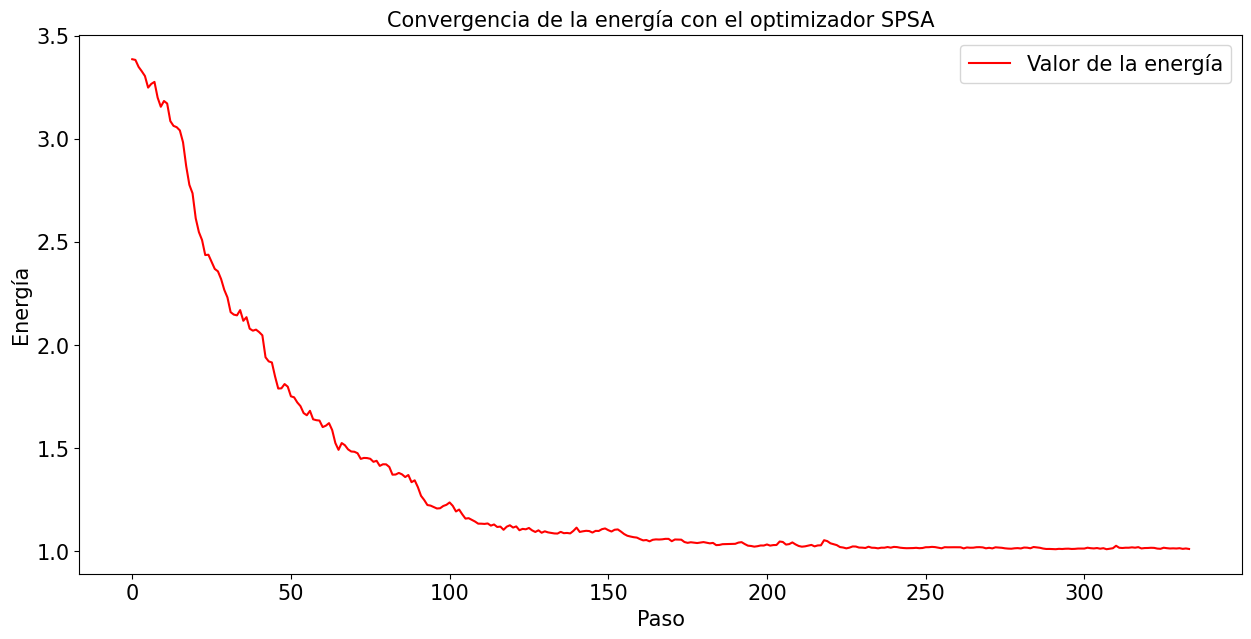

In [15]:
# Con la información de las iteraciones podemos dibujar la convergencia de nuestro código

fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(result_energy)), result_energy, label="Valor de la energía", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Paso', fontsize = fontsize)
plt.ylabel('Energía', fontsize = fontsize)
plt.title('Convergencia de la energía con el optimizador SPSA', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize)
plt.show()